# Image Classification Transfer Learning and Fine-Tuning using the EfficientNetB0 model on the Food101 dataset

A simple CNN(convolutional neural network) transfer learning application with fine tuning is done here using the [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) model on the food101 dataset from [tensorflow datatsets](https://www.tensorflow.org/datasets/catalog/food101).

**EfficientNet**, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946) is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks. We will be using the **EfficientNetB0** architecture as it is the least complex and works on images with lesser size.

             

<p style="text-align:center;font-size:18px;"><b>The EfficientNet family models compared to other models based on ImageNet</b>
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png" width="600" height="600"></p>
<p style="text-align:center;">Source: <a href="https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html">Google AI Blog</a></p>

As seen from the image, even though the Top-1 Accuracy of **EfficientNetB0** is comparatively low, we will be using it in this experiment to implement transfer learning, feature extraction and fine-tuning. The other higher model architectures in the EfficientNet family will require even more computationally powerful hardware.

We begin by importing the neccessary packages:

In [1]:
#importing the necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#centering our plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

As the dataset contains 75750 train images and 25250 test images, it can be classified as a large dataset. We want to make sure, we use the GPU for computing on this large dataset as it can significantly reduce the processing, computation and training times.

In [3]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-75f6c570-b9ee-76ef-47cd-a5fe65710429)


Great, my laptop's GPU is in use.

### Importing and Inspecting the Data

We create the train and test datasets using the `tfds.load()` function. The `shuffle_files` parametet is set to `False` as we will be separately shuffling the train dataset images later while keeping the test dataset un-shuffled as we will want to compare the test set with the predicted set after evaluation on the test dataset. We also set the `as_supervised` parameter to `True` as we want a clean dataset in the `('image', 'label')` format.
>**Note**: The below step may take a long time (~1 hour) depending upon your network speed and processing power as Tensorflow downloads the whole Food101 dataset and stores it locally (about 4.65 GiB)

In [4]:
(train_data, test_data), ds_info = tfds.load("food101",
                                             data_dir="D:\Food Vision",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             with_info=True,
                                             as_supervised=True)

We print the metadata information on the dataset which is saved into `ds_info` obtained by passing the `wiht_info = True` argument and get a bunch of metadata information on the dataset structure.

In [5]:
print(ds_info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    data_path='D:\\Food Vision\\food101\\2.0.0',
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=75750, num_shards=32>

A quick check on the number of images in the train and test datasets confirms that train dataset contains 75750 images (750 images per class) and the test dataset contains 25250 images (250 images per class) over 101 classes:

In [6]:
len(train_data), len(test_data)

(75750, 25250)

Calling the `features` method on `ds_info` yields the dataset structure which is currently in the form of a dictionary where the keys are `image` and their corresponding `label`. Their datatypes are `uint8` and `int64` respectively.

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

The class names of all the 101 food classes can be obtained by calling the `names` method on the `label` key from the dictionary. The first ten class names and the length of the list are displayed:

In [8]:
class_names = ds_info.features['label'].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

### Preprocessing

As EfficientNetB0 works best with images of size `(224, 224, 3)`, it is essential that we convert all the images in our datasets to the said size. We do this by defining a function which we can later map to all the elements in the train and test datasets. Oh, and also since neural networks work best with `float32` or `float16` datatypes, we need to convert the `uint8` datatype of the images to `float32` datatype.

In [9]:
def resize_images(image, label):
    image = tf.image.resize(image, size=(224,224))
    image = tf.cast(image, dtype = tf.float32)
    return image, label

Now that we have defined the required function to resize the image, change the datatype and return a tuple of the image and its associated label, we will now map the created function across all elements of the dataset. At this stage, we also create a performance pipeline to fit the datasets in memory and speed up computations and processing. The `num_parallel_calls` parameter in the `map()` function is set to `tf.data.AUTOTUNE` which automatically tunes the mapping function to increase parallel processing efficiency. Next, we shuffle only the train dataset with a buffer size of `1000` so as to not consume a lot of memory at once and we also split the train and test datasets into batches of `32` since we cannot fit all the images in the train dataset into the GPU's bandwidth at once. We also make use of `prefetch()` which overlaps the preprocessing and model execution of a training step thereby increasing efficiency and decreasing the time take during training. Here too, we set the `buffer_size` parameter to `tf.data.AUTOTUNE` to let Tensorflow automatically tune the buffer size. You can read more about prefetching [here](https://www.tensorflow.org/guide/data_performance#prefetching).

In [10]:
train_data = train_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#test_data doesn't need to be shuffled
test_data = test_data.map(map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

Now that we have preprocessed our train and test datasets, an important step would be to visualize the images in the dataset. We run the following code to randomly visualize 9 images across the train dataset. The image is divided by `255` as the `plt.imshow()` function outputs the visualization in the correct format only if all the values in the image tensor are between `0` and `1`. We also print the class name and the corresponding class label of the visualized image from the train dataset:

>**Note**: Every time this code block is run, it displays another set of random images. This is really useful to go through a few iterations and check the structure of our dataset and any labelling mistakes or other data input issues, if they occur.

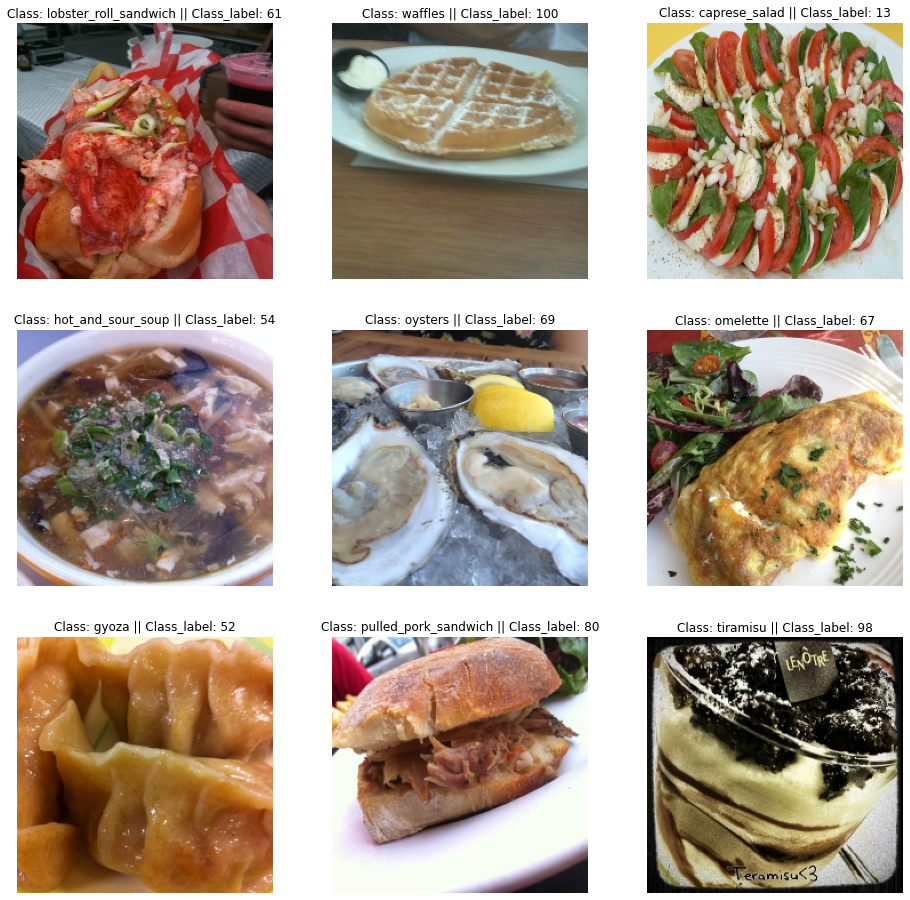

In [11]:
plt.figure(figsize=(16,16))
for i in range(9):
    for image,label in train_data.take(1):
        image = image/255.
        plt.subplot(3,3,i+1)
        plt.imshow(image[0])
        plt.title("Class: " + class_names[label[0].numpy()] + " || Class_label: " + str(label[0].numpy()))
        plt.axis(False);

Now that we have passed the `resize_images()` function to our datasets to resize the images and change the datatype, we can use the `element_spec` attribute to check the properties of the datasets:

In [12]:
train_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

Great! Now all the images are of size `(224, 224, 3)` and the datatypes are of the `float32` datatype. The `None` shape indicates that the images and labels have been split into batches which we specified earlier.

Oh and another thing we could do to increase our processing speed and thereby decrease the time taken to train a neural network in the process is by implementing the `mixed_precision` training from the `keras` module. Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. The Keras mixed precision API allows us to use a mix of float16 with float32, to get the performance benefits from float16 and the numeric stability benefits from float32. You can read more about `mixed_precision` training [here](https://www.tensorflow.org/guide/mixed_precision).

In [13]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [14]:
mixed_precision.global_policy()

<Policy "mixed_float16">

We can see that the global datatype policy for our session is currenly set to `mixed_float16`. Also another thing to keep in mind is that, as of now, mixed precision training works only on GPUs with a compute capability of `7.0` or higher. We can see that my GPU is mixed precision training capable with a compute capability of `8.6`. Thank you Nvidia!

Before we start with the actual transfer learning and fine-tuning, we will create some handy callbacks to implement during training. The first will be the `TensorBoard` callback which can produce well-deinfed graphs and visualizations of our model's metrics on the Tensorboard Dev site. To do this, we simply provide a path to store the callback during training.

Secondly, we will create a `ModelCheckpoint` callback which will create a checkpoint of our model which we can later revert back to, if needed. Here we save only the weights of the model and not the whole model itself as it can take some time. The validation accuracy is the metric being monitored here and we also set the `save_best_only` parameter to `True` and so the callback will only the save the weights of the model which has led to the highest validation accuracy.

In [15]:
def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

def model_checkpoint(directory, name):
    log_dir = directory + "/" + name
    m_c = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir,
                                             monitor="val_accuracy",
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
    return m_c

### Creating our Feature Extraction Model

Okay now that we have preprocessed our data, visualized and created some handy callbacks, we move on the the acutal transfer learning part! We create the base model with `tf.keras.applications.efficientnet` and choose `EfficientNetB0` from the list of available EfficientNet prebuilt models. We also set the `include_top` parameter to `False` as we will be using our own output classifier layer suited to our food101 classification application. Since we are just feature extracting and not fine-tuning at this point, we will set `base_model.trainable = False`.

In [16]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

Now that we have our feature extraction base model ready, we will use the Keras Functional API to create our model which include the base model as functional layer for our feature extraction training model. The input layer is first created with the shape set to `(224, 224, 3)`. The base model layer is then instantiated by passing the input layer while also setting the `training` parameter to `False` as we are not into fine-tuning the model yet. Next, the `GlobalAveragePooling2D` layer is set up to perform the pooling operation for our convolutional neural network. After that, a small change is done where this model differs from the conventional CNN, where the output layer is split separately into the `Dense` and `Activation` layers. Usually for any classification, the **softmax** activation can be included along with the output Dense layer. But here, since we have implemented **mixed_precision** training, we pass the **Activation** layer separately at the end as we want the output from the softmax activation to be of the `float32` datatype which will rid us of any stability errors by maintaining numeric stability. Finally, the model is created by using the `Model()` function.

In [17]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = layers.Dense(101, name='outputLayer')(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

model = tf.keras.Model(inputs, outputs, name = "FeatureExtractionModel")

Now that we have built the model with just feature extraction included, we use the `summary()` method to get a look at the architecture of our feature extraction model:

In [18]:
model.summary()

Model: "FeatureExtractionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 101)               129381    
_________________________________________________________________
activationLayer (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


We see that the whole base model (EfficientNetB0) is implemented as a single functional layer in our feature extraction model. We also see the other layers created for building our model. The base model contains about 4 million parameters but they are all non-trainable since we have frozen the base model as we are not fine tuning but rather only extracting the features from the base model. The only trainable parameters come from the output Dense layer.

Next, we get a detailed look at the various layers in our feature extraction model, their names, see if they are trainable or not, their data types and their corresponding data type policies.

In [19]:
for lnum, layer in enumerate(model.layers):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 inputLayer True float32 <Policy "float32">
1 efficientnetb0 False float32 <Policy "mixed_float16">
2 poolingLayer True float32 <Policy "mixed_float16">
3 outputLayer True float32 <Policy "mixed_float16">
4 activationLayer True float32 <Policy "float32">


We can see that all the layers excepting the base model layer are trainable. The datatype policies indicate that apart from the input layer and the output activation layer which have `float32` datatype policy, all the other layers are compatible with and employ the `mixed_float16` datatype policy.

Now we can move on to compiling and fitting our model. Since our labels are not one-hot encoded, we use the `SparseCategoricalCrossentropy()` loss function. We use the `Adam()` optimizer with its default learning rate and set the model metrics to measure `accuracy`.

Then we begin to fit our feature extraction model. We save the model fitting history variable into `hist_model` and we train our model on the train dataset for 3 epochs. We use our test dataset as the validation data while training and use 10% of the test data as the validation step count to decrease the time taken for each epoch. We also pass the previously created callback functions into the `callbacks` list to create a TensorBoard Dev visualization and also a ModelCheckpoint which saves our model's best weights while monitoring the validation accuracy. 

In [20]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

hist_model = model.fit(train_data,
                       epochs = 3,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(0.1 * len(test_data)),
                       callbacks=[tensorboard_callback("Tensorboard","model"),
                                  model_checkpoint("Checkpoints","model.ckpt")])

C:\Python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/3
2368/2368 [==============================] - 115s 43ms/step - loss: 1.8228 - accuracy: 0.5578 - val_loss: 1.2524 - val_accuracy: 0.6665

Epoch 00001: val_accuracy improved from -inf to 0.66653, saving model to Checkpoints\model.ckpt
Epoch 2/3
2368/2368 [==============================] - 97s 41ms/step - loss: 1.2952 - accuracy: 0.6656 - val_loss: 1.1330 - val_accuracy: 0.6946

Epoch 00002: val_accuracy improved from 0.66653 to 0.69462, saving model to Checkpoints\model.ckpt
Epoch 3/3
2368/2368 [==============================] - 100s 42ms/step - loss: 1.1449 - accuracy: 0.7024 - val_loss: 1.0945 - val_accuracy: 0.7021

Epoch 00003: val_accuracy improved from 0.69462 to 0.70214, saving model to Checkpoints\model.ckpt


Wow! I was expecting the training time for each epoch to take a lot longer. It seems like our input data pipelining, GPU and the mixed_precision policy implementation have really helped us reduce the time take for training significantly.                 
Hmm... our training and validation accuracies are not that bad considering we have 101 output classes. We have also created a model checkpoint with the model weights leading to the highest validation accuracy incase we want to revert back to it after fine-tuning in the next stage. Let us evaluate our model on the whole test data now and store it in a variable.

In [21]:
model_results = model.evaluate(test_data)

790/790 [==============================] - 27s 34ms/step - loss: 1.0932 - accuracy: 0.7053


Not bad, not bad at all. **70.53**% accuracy is pretty decent for just a feature extraction model.

### Fine Tuning our Feature Extraction Model

We have got an accuracy of about 70.53% with our feature extraction model based on the EfficientNetB0 base model. How about we try to increase the accuracy score by fine-tuning our feature extraction model now. To do this, we set the layers of our model's base_model (the EfficientNetB0 functional layer) to be trainable and unfreeze the previously frozen base model.

In [22]:
base_model.trainable = True

However, The `BatchNormalization` layers need to be kept frozen. If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy ([details here](https://keras.io/guides/transfer_learning/)). Since all the layers in the base model have been set to trainable, we use the following code block to again freeze only the **BatchNormalization** layers of our base model:

In [23]:
for layer in model.layers[1].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

A quick check on the base model's layers, their datatypes and policies and whether or not they're trainable:

In [24]:
for lnum, layer in enumerate(model.layers[1].layers[-20:]):
    print(lnum, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 block6d_project_conv True float32 <Policy "mixed_float16">
1 block6d_project_bn False float32 <Policy "mixed_float16">
2 block6d_drop True float32 <Policy "mixed_float16">
3 block6d_add True float32 <Policy "mixed_float16">
4 block7a_expand_conv True float32 <Policy "mixed_float16">
5 block7a_expand_bn False float32 <Policy "mixed_float16">
6 block7a_expand_activation True float32 <Policy "mixed_float16">
7 block7a_dwconv True float32 <Policy "mixed_float16">
8 block7a_bn False float32 <Policy "mixed_float16">
9 block7a_activation True float32 <Policy "mixed_float16">
10 block7a_se_squeeze True float32 <Policy "mixed_float16">
11 block7a_se_reshape True float32 <Policy "mixed_float16">
12 block7a_se_reduce True float32 <Policy "mixed_float16">
13 block7a_se_expand True float32 <Policy "mixed_float16">
14 block7a_se_excite True float32 <Policy "mixed_float16">
15 block7a_project_conv True float32 <Policy "mixed_float16">
16 block7a_project_bn False float32 <Policy "mixed_float16">
17 

Good! Looks like all the layers in the base model are trainable and ready for fine tuning except for the `BatchNormalization` layers. I think we are good to proceed and fine tune our feature extraction model `'model'`. We begin by compiling the model again since we have change the layer attributes (unfreeze), but this time, as a general good practice, we reduce the default learning rate of the `Adam()` optimizer by ten times so as to reduce overfitting and stop the model from learning/memorizing the train data to a great extent.      

Then we begin to fit our fine tuning model. We save the model fitting history variable into `hist_model_tuned` and we train our model on the train dataset for 5 epochs, however, we set the initial epoch to be the last epoch from our feature extraction model training which would be `3`. Thus the fine tuning model training would start from epoch number **3** and would run upto 5 (three epochs total). We use our test dataset as the validation data while training and use 10% of the test data as the validation step count to decrease the time taken for each epoch. We again pass the previously created callback functions into the callbacks list to create a TensorBoard Dev visualization for comparison between the feature extraction and this fine tuning models and also a ModelCheckpoint which saves our model's best weights while monitoring the validation accuracy.

In [25]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])
hist_model_tuned = model.fit(train_data,
                             epochs=5,
                             steps_per_epoch=len(train_data),
                             validation_data=test_data,
                             validation_steps=int(0.1*len(test_data)),
                             initial_epoch=hist_model.epoch[-1],
                             callbacks=[tensorboard_callback("Tensorboard", "model_tuned"),
                                        model_checkpoint("Checkpoints", "model_tuned.ckpt")])

Epoch 3/5
2368/2368 [==============================] - 313s 127ms/step - loss: 0.9206 - accuracy: 0.7529 - val_loss: 0.8053 - val_accuracy: 0.7757

Epoch 00003: val_accuracy improved from -inf to 0.77571, saving model to Checkpoints\model_tuned.ckpt
Epoch 4/5
2368/2368 [==============================] - 297s 125ms/step - loss: 0.5628 - accuracy: 0.8457 - val_loss: 0.8529 - val_accuracy: 0.7678

Epoch 00004: val_accuracy did not improve from 0.77571
Epoch 5/5
2368/2368 [==============================] - 298s 125ms/step - loss: 0.3082 - accuracy: 0.9132 - val_loss: 0.8977 - val_accuracy: 0.7801

Epoch 00005: val_accuracy improved from 0.77571 to 0.78006, saving model to Checkpoints\model_tuned.ckpt


Okay great! Looks like the validation accuracy has improved a lot. Let's evaluate our fine-tuned model on the whole test data now and store it in a variable.

In [26]:
model_tuned_results = model.evaluate(test_data)

790/790 [==============================] - 26s 33ms/step - loss: 0.9043 - accuracy: 0.7772


Would you look at that! The fine-tuned model's accuracy has improved by about 10% and is now at about **77.72**%. That is a huge increase we have achieved with just transfer learning and fine-tuning. Thanks EfficientNet for your model!

As a comparison, [Deep Food](https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf)'s Convolutional Neural Network model implemented back in **June** of **2016** had achieved a Top-1 Accuracy of **77.4**%. Our model is almost on par with it or slightly better even just by using simple transfer learning techniques and fine tuning. Training for more epochs and adding regularization techniques to reduce overfitting among other methods can surely improve our fine tuned model's accuracy score. We could also save our model to a directory at this point using the `.save()` function to use it outside of our local runtime.

Since we have created `TensorBoard` callbacks, we can upload the saved TensorBoard logs in the specified directory to TensorBoard Dev. The obtained link can be clicked to view the model's metric visualizations online in TensorBoard Dev.

In [27]:
!tensorboard dev upload --logdir ./Tensorboard \
 --name "Food101"\
 --description "Feature Extraction Model vs Fine Tuned Model"\
 --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/hveaY1MSQBK6wIN6MwXoHA/

[2021-11-16T23:06:17] Started scanning logdir.
Data upload starting...
Uploading binary object (884.4 kB)...
Uploading binary object (1.1 MB)...
Uploading 36 scalars...
[2021-11-16T23:06:22] Total uploaded: 36 scalars, 0 tensors, 2 binary objects (2.0 MB)
[2021-11-16T23:06:22] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/hveaY1MSQBK6wIN6MwXoHA/


Since we have created two history objects for both the feature extraction model and the fine-tuned model, we can create a function to plot both the histories together and compare the training and the validation metrics to get a general idea of the performance of both models:

In [28]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(9, 9))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Great! Now let us use both the `hist_model` and `hist_model_tuned` objects along the function with the `initial_epochs` set to `3` since we trained our first feature extraction model for 3 epochs.

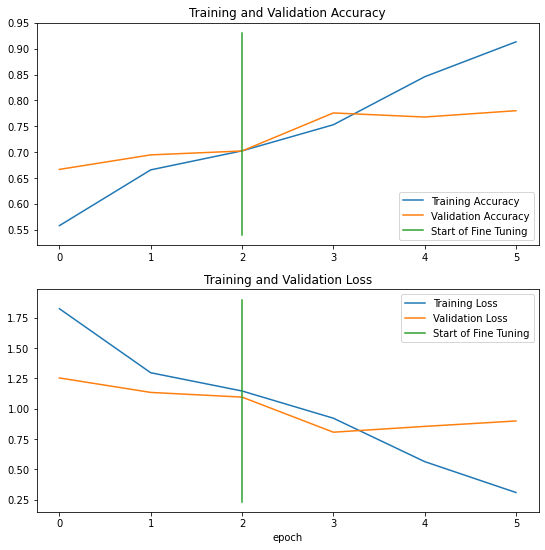

In [29]:
compare_histories(hist_model, hist_model_tuned, initial_epochs=3)

Hmm... that is a good plot. The training and validation curves look good for the feature extraction model, however, after fine-tuning, after just one epoch, the training loss decreases significantly while the training accuracy increases sharply. All this time, the validation accuracy and loss begin to plateau. This surely denotes that our model is over-fitting after an epoch. Other regularization techniques including drop-outs, augmentation and Early-Stopping callback techniques can be used to reduce over-fitting and maybe improve our model's accuracy scores on unseen test data. However, we will not be exploring them now as this experiment was just to showcase the incredible power of transfer learning and fine-tuning with just a few easy steps.

### Predictions

Now that we have trained our fine-tuned model based on EfficientNetB0, we will use it to make predictions on the whole test dataset and store it in `preds`:

In [30]:
preds = model.predict(test_data, verbose = 1)

790/790 [==============================] - 27s 32ms/step


Note: The predictions are stored in a collection of prediction probabilities for each class for an individual test image.

Now that we have the prediction probabilities for each class for a given test image, we can easily obtain the prediction labels using the `tf.argmax()` function which returns the index which contains the highest probability along a given axis. We store the prediction labels in `pred_labels`:

In [31]:
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100], dtype=int64)>

Now that we have made predictions and obtained the prediction labels, we can compare it with the test dataset labels to get detailed information on how well the fine-tuned model has made its predictions. We get the test labels from the test dataset using the following code block employing list comprehension:

In [32]:
test_labels = np.concatenate([y for x, y in test_data], axis=0)
test_labels[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100], dtype=int64)

Great! We now have both the predicted labels and the ground truth test labels. However to plot our prediction labels along with the associated image, we will need a dataset containing only the images extracted from `test_data` which contains both the images along with the labels. To do this, two steps are needed. First, we create an empty list and pass a `for` loop which extracts and appends each batch from the test dataset using the `take()` function to the newly created empty list `test_image_batches`. The `-1` inside the `take()` function makes the `for` loop to pass through **all** the batches in the test data. The resulting output is a list of all the batches in the test data. Since the images are still in batches in the form of sublists inside the list `test_image_batches`, in step 2, we use list comprehension to extract each sublist, i.e each image from the main list and store them in the `test_images` list. The resulting list `test_images` contains all the `25250` test images contained in the original test dataset which is verified by using the `len()` funtion on the list.

In [33]:
# Step 1
test_image_batches = []
for images, labels in test_data.take(-1):
    test_image_batches.append(images.numpy())

# Step 2
test_images = [item for sublist in test_image_batches for item in sublist]
len(test_images)

25250

Now that we have a list of test images(`test_images`), their ground truth test labels(`test_labels`) and their corresponding prediction labels(`pred_labels`) along with the prediction probabilities (`preds`), we can easily visualize the test images along with their predictions including the ground truth and prediction class names.    

Here, we take 9 random images from `test_images` and plot them along with the ground truth class names and predicted class names in the plot title, side by side using indexing on `class_names` with the corresponding ground truth and predicted labels. We also display the prediction probabilities of the predictions on each image to get an idea of how confident the model is in its predictions. Moreover, to make the plots looke good and more informative, for wrong predictions, we set the title color to red, whereas for correct predictions by our fine-tuning model, we set the title color to green.

>**Note**: Each time this code block is run, it display a new random set of images and their predictions, this can be particularly useful in identifying two similar looking food classes where our model might get confused or an instance where our model has correctly predicted an image but it falls into the wrongly predicted category because of a wrong ground truth test label.

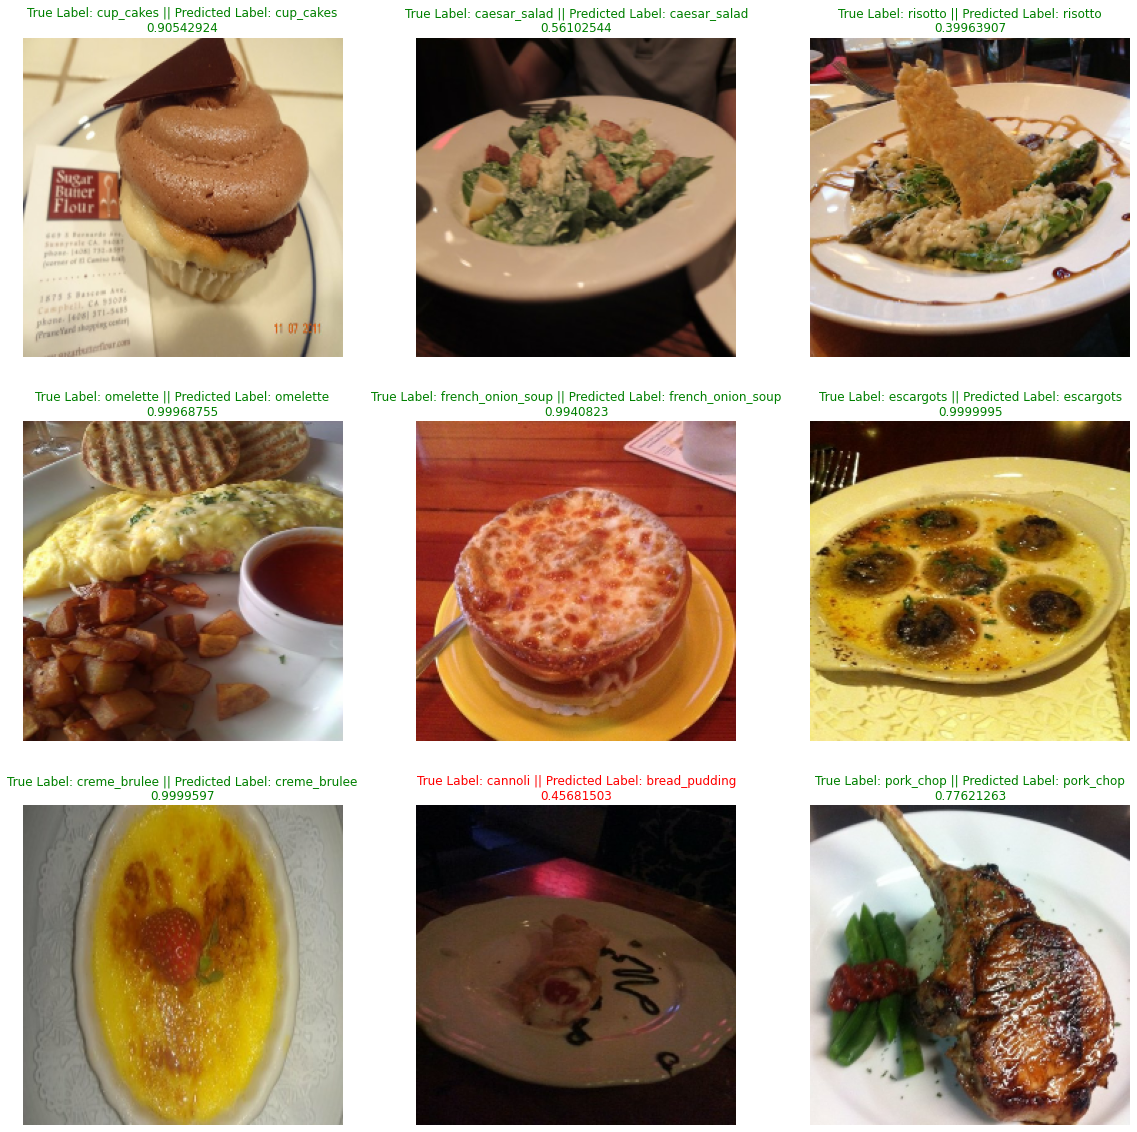

In [34]:
plt.figure(figsize = (20,20))
for i in range(9):
    random_int_index = random.choice(range(len(test_images)))
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[random_int_index]/255.)
    if test_labels[random_int_index] == pred_labels[random_int_index]:
        color = "g"
    else:
        color = "r"
    plt.title("True Label: " + class_names[test_labels[random_int_index]] + " || " + "Predicted Label: " +
              class_names[pred_labels[random_int_index]] + "\n" + 
              str(np.asarray(tf.reduce_max(preds, axis = 1))[random_int_index]), c=color)
    plt.axis(False);

### Model Evaluation

As we have both the test and prediction labels, we can also use the `classification_report()` function from **SciKit-Learn** library and store the `precision`, `recall` and `f1-scores` for each class in a dictionary `report` by specifying the `output_dict` parameter to be `True`. 

In [35]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, pred_labels, output_dict=True)

#check a small slice of the dictionary
import itertools
dict(itertools.islice(report.items(), 5))

{'0': {'precision': 0.5535055350553506,
  'recall': 0.6,
  'f1-score': 0.5758157389635316,
  'support': 250},
 '1': {'precision': 0.8383838383838383,
  'recall': 0.664,
  'f1-score': 0.7410714285714286,
  'support': 250},
 '2': {'precision': 0.9023255813953488,
  'recall': 0.776,
  'f1-score': 0.8344086021505377,
  'support': 250},
 '3': {'precision': 0.7297297297297297,
  'recall': 0.864,
  'f1-score': 0.7912087912087912,
  'support': 250},
 '4': {'precision': 0.7567567567567568,
  'recall': 0.672,
  'f1-score': 0.7118644067796612,
  'support': 250}}

Now that we have a dictionary containing the various evaluation metrics (`precision`, `recall` and `f1-scores`), how about we create a `pandas` dataframe which contains only the class names along with its corresponding F1-score. We choose the F1-score among the evaluation metrics as it achieves a balance between the precision and recall. You can read more about evaluation metrics [here](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/).    

However, in order to create that required dataframe, we will need to extract the class labels(keys) and the corresponding F1-score(part of values) from the classification report dictionary. This can be achieved by creating an empty dictionary `f1scores` and passing a `for` loop which goes through the original dictionary `report`'s items(keys and values) and appends the class names using key-indexing and the corresponding F1-score by value-indexing.

In [36]:
f1scores = {}
for k,v in report.items():
    if k == 'accuracy':
        break
    else:
        f1scores[class_names[int(k)]] = v['f1-score']
        
#check a small slice of the dictionary
dict(itertools.islice(f1scores.items(), 10))

{'apple_pie': 0.5758157389635316,
 'baby_back_ribs': 0.7410714285714286,
 'baklava': 0.8344086021505377,
 'beef_carpaccio': 0.7912087912087912,
 'beef_tartare': 0.7118644067796612,
 'beet_salad': 0.685483870967742,
 'beignets': 0.8489483747609943,
 'bibimbap': 0.900398406374502,
 'bread_pudding': 0.5907335907335908,
 'breakfast_burrito': 0.7020785219399538}

Now that we have the required dictionary ready, we can easily create a dataframe `F1` form the following line of code and sort the dataframe by the descending order of the various classes' **F1-scores**:

In [37]:
F1 = pd.DataFrame({"Classes":list(f1scores.keys()),
                   "F1-Scores":list(f1scores.values())}).sort_values("F1-Scores", ascending=False)

#check a small slice of the dataframe
F1[:10]

Classes  F1-Scores
33              edamame   0.983871
63             macarons   0.929860
69              oysters   0.925253
54    hot_and_sour_soup   0.923077
75                  pho   0.917647
88        seaweed_salad   0.913481
91  spaghetti_carbonara   0.909091
64            miso_soup   0.903885
86              sashimi   0.903640
76                pizza   0.901468

Great! It seems like the food class `edamame` has achieved the highest F1-score among all the classes followed by `macarons`. What's stopping us from creating a neat bar chart visualization displaying all the 101 food classes and their F1-scores in a descending order?

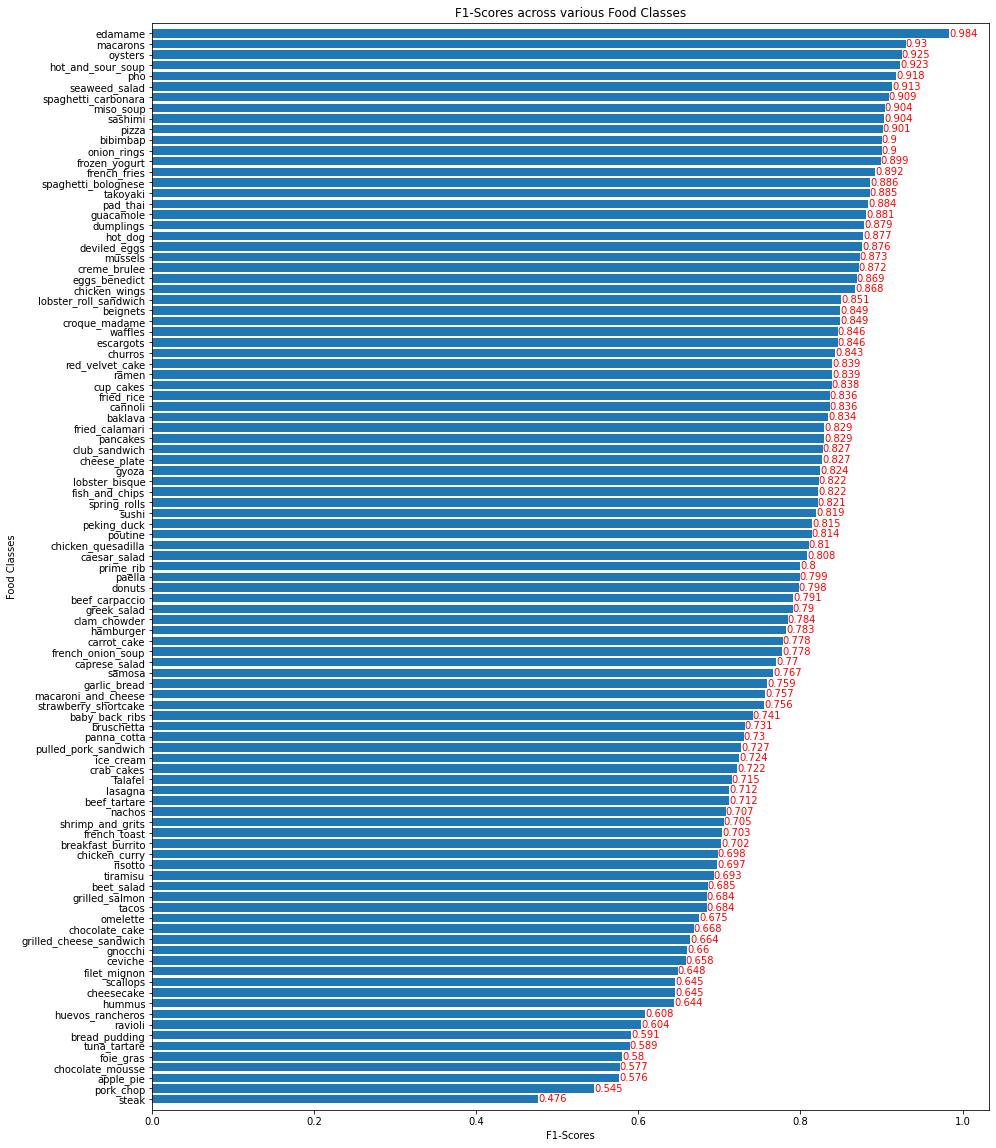

In [38]:
fig, ax = plt.subplots(figsize = (15,20))
plt.barh(F1["Classes"], F1["F1-Scores"])
plt.ylim(-1,101)
plt.xlabel("F1-Scores")
plt.ylabel("Food Classes")
plt.title("F1-Scores across various Food Classes")
plt.gca().invert_yaxis()
for i, v in enumerate(round(F1["F1-Scores"],3)):
    ax.text(v, i + .25, str(v), color='red');

<p style="text-align:center;"><img src="https://cdn.shopify.com/s/files/1/0402/4460/9184/products/edamame-beans-559400_grande.jpg?v=1619778459" width="270" height="270"></p>
<p style="text-align:center;"><i>Edamame</i></p>  



Fantastic! The food class `edamame` has the highest number of correct predictions while the class `steak` has the lowest F1-score, by far, indicating the lowest number of correct predictions. Hmm.. that's kinda sad because we all love steak!

As a final evaluation step for our transfer learning fine-tuned model based on the EfficientNetB0 let's visualize the *most wrong* predictions of our model, i.e the false(wrong) predictions of our model where the prediction probability is the highest. This will help us get an idea about our model as to whether it is getting confused on similar food classes or whether a test image has been wrongly labelled which would be a data input error.

To do this, let'ss create a neat dataframe `Predictions` which contains the 'Image Index' of the various images in the test dataset, their corresponding 'Test Labels', 'Test Classes', 'Prediction Labels', 'Prediction Classes', and 'Prediction Probability'.

In [39]:
Predictions = pd.DataFrame({"Image Index" : list(range(25250)), 
                            "Test Labels" : list(test_labels), 
                            "Test Classes" : [class_names[i] for i in test_labels],
                            "Prediction Labels" : list(np.asarray(pred_labels)),
                            "Prediction Classes" : [class_names[i] for i in pred_labels],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(preds, axis = 1))]})

As we have created the required dataframe `Predictions`, we can also create a new column 'Correct Prediction' which contains `True` for test images that have been correctly predicted by our model and `False` for wrongly predicted test images:

In [40]:
Predictions["Correct Prediction"] = Predictions["Test Labels"] == Predictions["Prediction Labels"]
Predictions[:10]

Image Index  Test Labels         Test Classes  Prediction Labels  \
0            0           29            cup_cakes                 29   
1            1           81                ramen                 81   
2            2           91  spaghetti_carbonara                 91   
3            3           53            hamburger                 53   
4            4           97             takoyaki                 97   
5            5           97             takoyaki                 97   
6            6           10           bruschetta                 10   
7            7           31               donuts                 31   
8            8            3       beef_carpaccio                  3   
9            9          100              waffles                100   

    Prediction Classes  Prediction Probability  Correct Prediction  
0            cup_cakes                0.995960                True  
1                ramen                0.869424                True  
2  spaghetti_carbonara                0.990043                True  
3            hamburger                0.985038                True  
4             takoyaki                0.999187                True  
5             takoyaki                0.848564                True  
6           bruschetta                0.930956                True  
7               donuts                0.999999                True  
8       beef_carpaccio                0.999982                True  
9              waffles                0.825195                True

Great, our dataframe looks fantastic! However, this is not the final form of our dataframe. We want to subset our current dataframe with only those records where 'Correct Prediction' is equal to `False` as our aim is to plot and visualize the *most wrong* predictions of our fine-tuning model. We obtain our final dataframe using the following code block and sort the dataframe records in the descending order of the **'Prediction Probability'**:

In [41]:
Predictions = Predictions[Predictions["Correct Prediction"] == False].sort_values("Prediction Probability", ascending=False)
Predictions[:10]

Image Index  Test Labels      Test Classes  Prediction Labels  \
15437        15437           56  huevos_rancheros                 66   
900            900           14       carrot_cake                 29   
9735          9735           87          scallops                 30   
9294          9294           75               pho                 81   
13884        13884           46      garlic_bread                 10   
2225          2225           43    fried_calamari                 20   
6717          6717           31            donuts                 29   
7455          7455           43    fried_calamari                 68   
810            810            5        beet_salad                 11   
22788        22788           63          macarons                 29   

      Prediction Classes  Prediction Probability  Correct Prediction  
15437             nachos                0.999990               False  
900            cup_cakes                0.999988               False  
9735        deviled_eggs                0.999987               False  
9294               ramen                0.999968               False  
13884         bruschetta                0.999945               False  
2225       chicken_wings                0.999935               False  
6717           cup_cakes                0.999907               False  
7455         onion_rings                0.999865               False  
810         caesar_salad                0.999822               False  
22788          cup_cakes                0.999801               False

Impressive! Our final dataframe `Predictions` contains only the wrongly predicted image records (image indexes) along with their ground truth test labels, test classes, predicted labels, prediction classes sorted by the descending order of their prediction probabilities. We can manually take an image index out of this dataset and pass it into a plot function on the test dataset to obtain a visualization of the image with its ground truth class name and the predicted class name. However, here we will take the first **9** images or image indexes which are the *most wrong* images in our dataframe and plot it along with the true class names, the predicted class names and the corresponding prediction probabilities.  

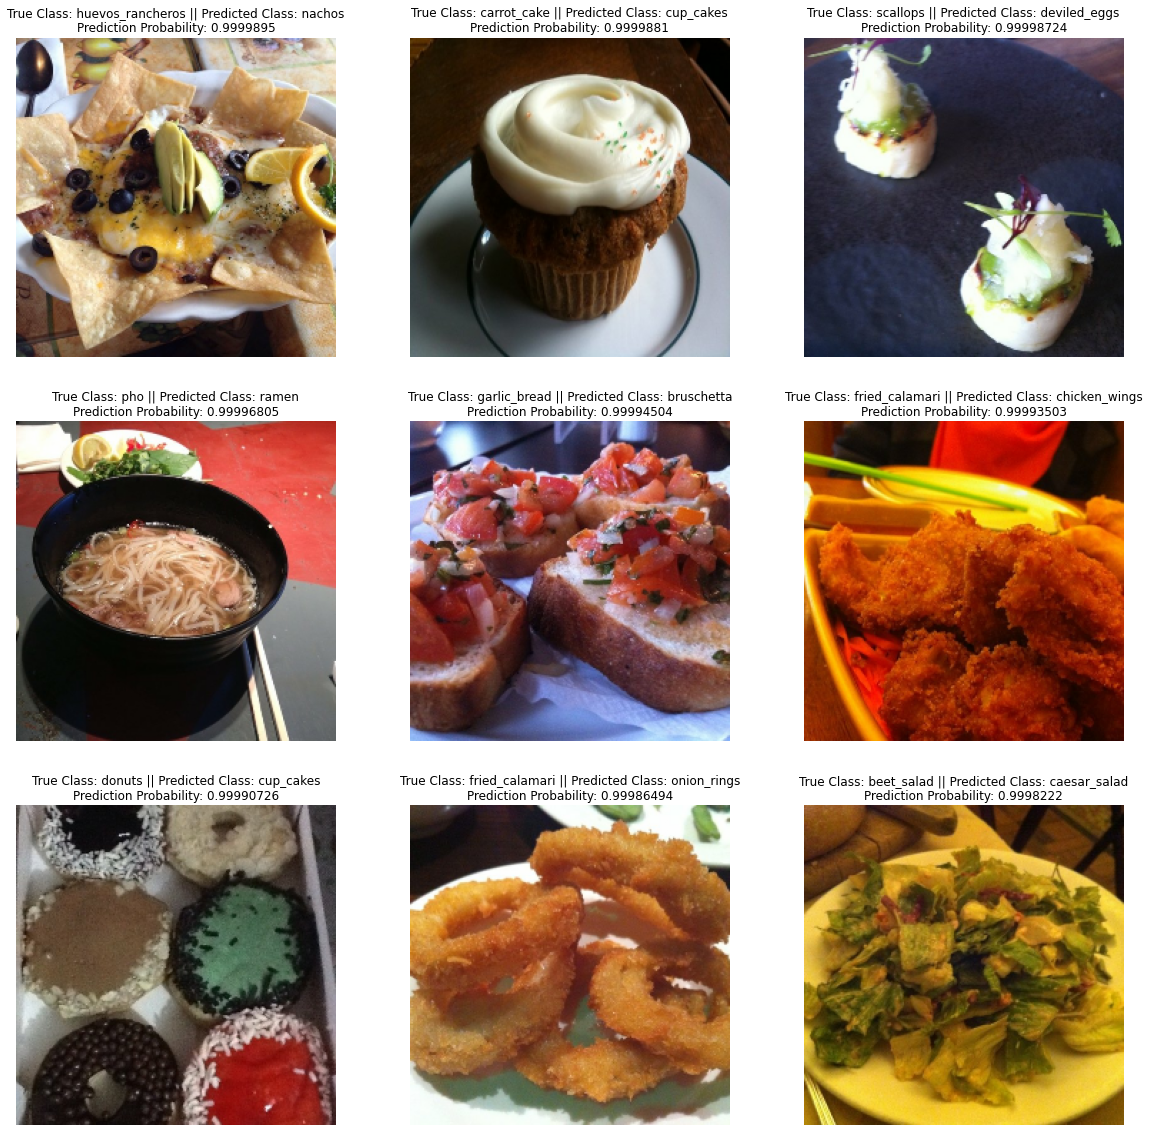

In [42]:
indexes = np.asarray(Predictions["Image Index"][:9]) #choosing the top 9 records from the dataframe
plt.figure(figsize=(20,20))
for i, x in enumerate(indexes):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[x]/255)
    plt.title("True Class: " + class_names[test_labels[x]] + " || " + "Predicted Class: " + class_names[pred_labels[x]] + "\n" +
             "Prediction Probability: " + str(np.asarray(tf.reduce_max(preds, axis = 1))[x]))
    plt.axis(False);

Well well well... what do you know! Through quick Google searches (yes, I don't know what most of these food class names are), it becomes pretty evident that in fact, the ground truth test labels for some test images have been wrongly labelled as in the case of the first image which is clearly not huevos rancheros but is indeed the class predicted by our model - nachos! Also, the fith image is clearly not garlic bread but is also the class predicted by our model - bruschetta! Extra points to our model! Other common wrong predictions arise from our model getting confused between similar looking food classes. For example the `chocolate_cake` in some images closely resembles `tiramisu` and in some cases would be really hard for even a human being to classify.

Good thing we decided to visualize the most wrong predictions! With this, we can perform appropriate data cleaning techniques to correct the wrong truth labels and maybe remove some really confusing similar looking food classes. After performing these corrections and adjustments, I think our fine-tuned model's accuracy can be increased drastically!

Again, while randomly going through the *most wrong* predicted images, I came across this image which is clearly true labelled `peking_duck` in the test dataset but is indeed `pad_thai`! Once more, this can be confirmed by a quick Google search and thus our model has actually made the correct prediction. Hmm... maybe many other images with wrong ground truth labels exist and if all of them are corrected, imagine our model's accuracy score!

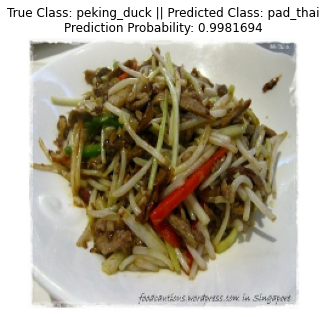

In [43]:
plt.figure(figsize=(5,5))
plt.imshow(test_images[11586]/255)
plt.title("True Class: " + class_names[test_labels[11586]] + " || " + "Predicted Class: " + class_names[pred_labels[11586]]
          + "\n" + "Prediction Probability: " + str(np.asarray(tf.reduce_max(preds, axis = 1))[11586]))
plt.axis(False);

<p style="text-align:center;"><img src="https://i.imgur.com/fDd6AfP.png" width="650" height="400"></p>
<p style="text-align:center;"><i>Peking Duck vs Pad Thai</i></p>  

___



<p style="text-align:center; font-size:30px;">Thank you for reading ☺</p>  

David Ben Gurion,     
RMIT University.      
[LinkedIn](https://www.linkedin.com/in/davidbengurion/)       
Please follow this publication on [Medium](https://medium.com/@davidbengurion1/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3)